In [1]:
import pandas as pd

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...,...
9420,2023-07-31,336.920013,337.700012,333.359985,335.920013,335.920013,25446000
9421,2023-08-01,335.190002,338.540009,333.700012,336.339996,336.339996,18311900
9422,2023-08-02,333.630005,333.630005,326.359985,327.500000,327.500000,27761300
9423,2023-08-03,326.000000,329.880005,325.950012,326.660004,326.660004,18253700


In [2]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9420,2023-07-31,335.920013
9421,2023-08-01,336.339996
9422,2023-08-02,327.500000
9423,2023-08-03,326.660004


In [3]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [4]:
df['Date'] = df['Date'].apply(str_to_datetime)

<ipython-input-4-82fc7f804c29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [5]:
df.index = df.pop('Date')

In [6]:
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-07-31,335.920013
2023-08-01,336.339996
2023-08-02,327.500000


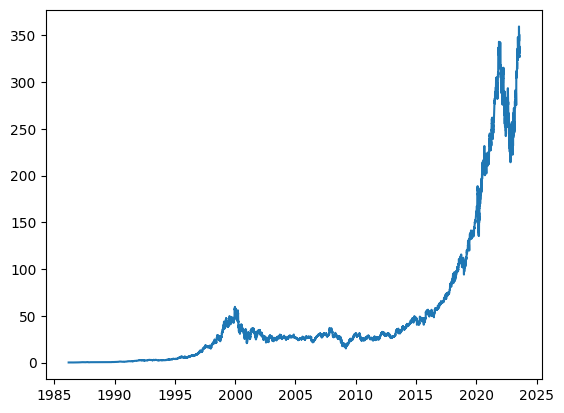

In [7]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [16]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2023-08-04',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
590,2023-07-31,337.769989,330.720001,338.369995,335.920013
591,2023-08-01,330.720001,338.369995,335.920013,336.339996
592,2023-08-02,338.369995,335.920013,336.339996,327.500000
593,2023-08-03,335.920013,336.339996,327.500000,326.660004


In [17]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((595,), (595, 3, 1), (595,))

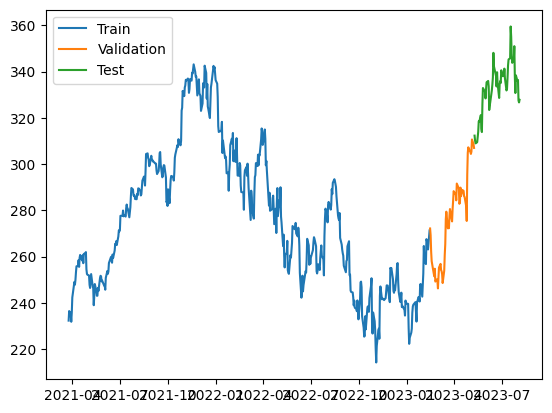

In [18]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15/15 [==============================] - 4s 47ms/step - loss: 76519.8906 - mean_absolute_error: 274.9487 - val_loss: 76392.8906 - val_mean_absolute_error: 275.7602
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 75968.2500 - mean_absolute_error: 273.9444 - val_loss: 75770.8750 - val_mean_absolute_error: 274.6300
Epoch 3/100
15/15 [==============================] - 0s 6ms/step - loss: 75122.9531 - mean_absolute_error: 272.3940 - val_loss: 74491.8828 - val_mean_absolute_error: 272.2918
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 73401.3047 - mean_absolute_error: 269.2156 - val_loss: 71938.8906 - val_mean_absolute_error: 267.5573
Epoch 5/100
15/15 [==============================] - 0s 6ms/step - loss: 69794.4922 - mean_absolute_error: 262.4106 - val_loss: 67462.1250 - val_mean_absolute_error: 259.0609
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 64627.3828 - mean_absolute_error: 252.3898 - val_lo

15/15 [==============================] - 1s 3ms/step


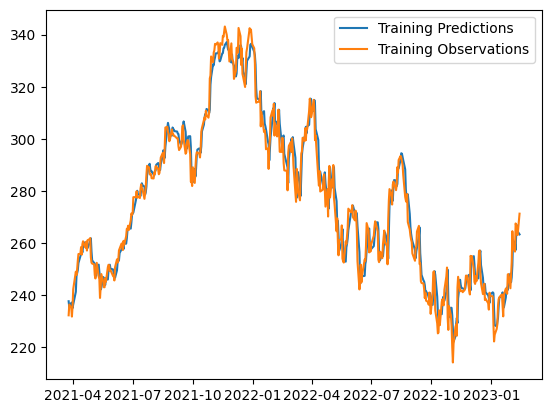

In [20]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 7ms/step


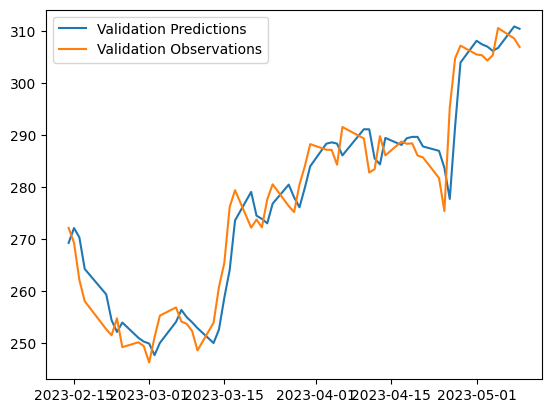

In [21]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 7ms/step


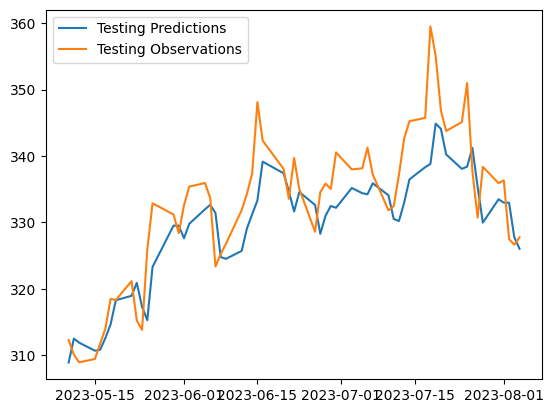

In [22]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

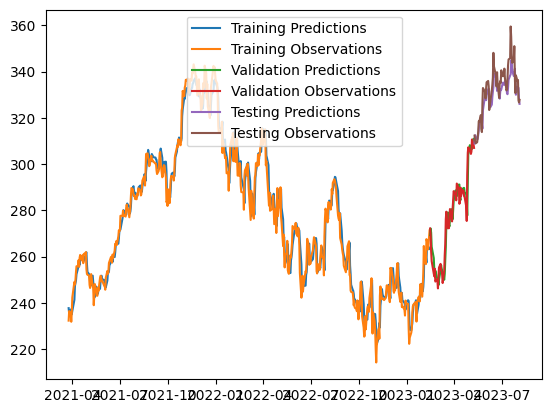

In [23]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])